In [1]:
%matplotlib inline
import pandas as pd 
from os import listdir
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import matplotlib
sns.set()
matplotlib.rcParams['figure.figsize'] = (20,10)
# import mpld3
# mpld3.enable_notebook()
# sns.set_style('darkgrid')
# sns.palplot(sns.light_palette("green"))

In [2]:
# Read csv filenames 
files = [name for name in listdir() if 'csv' in name]
fileName = files[0]
fileName = '866192035974276_AXIO.csv'

FileName: 864811036264054_TOWNACE.csv
       engine_status  main_battery_status  voltage created_at  fuel_litre
1210             1.0                  0.0   -880.0   00:17:15    5.395647
1317             1.0                  0.0   -972.0   00:00:08    6.457694
1325             1.0                  0.0   -967.0   00:02:40    6.624204
1371             1.0                  0.0   -921.0   00:00:03    5.914487
1391             1.0                  0.0   -968.0   00:00:09    6.568731
1491             1.0                  0.0   -888.0   00:00:05    5.282916
1570             1.0                  0.0   -973.0   00:15:51    6.638067
1600             1.0                  0.0  -1005.0   00:01:11    7.066925
1839             1.0                  0.0  -1187.0   00:00:05    9.559210
1858             1.0                  0.0  -1186.0   00:18:06    9.545815
2136             1.0                  0.0  -1280.0   00:00:03   10.778080
2773             0.0                  0.0  -1738.0   00:04:23   16.355362


/home/clueless/anaconda3/lib/python3.6/site-packages/pandas/plotting/_core.py:1716: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  series.name = label


KeyError: 'receive_time'

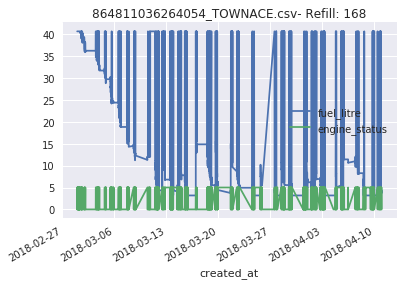

In [3]:
for fileName in files:
    # Read a file as dataframe 
    df = pd.read_csv(fileName)

    # Drop all Unnamed Columns
    df = df.loc[:, ~df.columns.str.contains('^Unnamed')]

    # Fixing the datatype 
    df['receive_time'] = pd.to_datetime(df['receive_time'])
    df['created_at'] = pd.to_datetime(df['created_at'])
    # Available columns 
    # df.columns.values

    # Drop the rows with NAN values 
    df = df.dropna(axis=0, how='any')

    drop = ['id','receive_time','velocity','ac_status','satellite_number','gps_availability','gsm_strength',
           'row_status','latitude_degree','longitude_degree','travel_distance_km','fuel_type','fuel_stability']
    df = df.drop(drop, axis = 1)

    #Check Datatypes 
    # df.dtypes
    df_shifted = df - df.shift()
    fuel_data = df['fuel_litre']
    df['engine_status'] = df['engine_status']*5
    # df.plot(x='created_at',y='engine_status')
    # plt.plot(df['created_at'], df['fuel_litre'])
    diff_fuel = (fuel_data - fuel_data.shift())

    print('FileName: {}'.format(fileName))
    print(df_shifted[diff_fuel >= 5])
    print('Total Number of refill: {}'.format(sum(diff_fuel>5)))
    df.plot(x=['created_at'], y=['fuel_litre','engine_status'], title=fileName + '- Refill: ' + str(sum(diff_fuel>5)))

In [ ]:
%%javascript
$('.nbp-app-bar').toggle()

In [ ]:
df.head()

In [ ]:
# Create New Columns to find Time_difference_between_consecutive_creation_of_data
df['time_difference'] = df['created_at'] - df['created_at'].shift()

# Convert time difference to seconds 
df['time_difference'] = df['time_difference'].dt.total_seconds()

# Create New Columns - diff between fuel_data
df['fuel_difference'] = df['fuel_litre'] - df['fuel_litre'].shift()

# Difference Between voltages 
df['voltage_difference'] = df['voltage'] - df['voltage'].shift()

In [ ]:
# Drop the rows with NAN values 
df = df.dropna(axis=0, how='any')
df = df.loc[df['fuel_litre'] < 40 ]
df = df.loc[df['fuel_litre'] > 4 ]

In [ ]:
df['travel_distance_km'].corr(df['fuel_difference'])

In [ ]:
%pylab inline 
import matplotlib as mpl
# mpl.rcParams['figure.figsize'] = (20,10)
mpl.rcParams['figure.dpi']= 300
import seaborn as sns
def standardize(series):
    return (series - series.mean())/series.std(ddof=0)
len(standardize(df['voltage']))
df.plot(x = 'created_at',y=['fuel_litre'])

In [ ]:
# eng = np.array(df['engine_status'])
# for i,en in enumerate(eng):
#     if i>0 and eng[i] == 1 and eng[i-1] ==0:
#         print(df['fuel_litre'][i:i+10].var())
#         var = df['fuel_litre'][i:i+100].var()
#         print('column: '+str(i))
#         if .5<var<1:
            
#             print('refill')

In [ ]:
df['fuel_litre'][1:10].var()

In [4]:
## Applying kalman Filter 
%matplotlib inline
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
from collections import namedtuple 
from ipywidgets import interact
import mpld3
mpld3.enable_notebook()
# mpl.rcParams['figure.figsize'] = (20,10)

gaussian = namedtuple('Gaussian', ['mean', 'var'])
gaussian.__repr__ = lambda s: '(={:.3f}, š={:.3f})'.format(s[0], s[1])

x = 10000
y = 11000
fuel = np.array(df['fuel_litre'])[10000:]
engine = np.array(df['engine_status'])
time = np.array(df['created_at'])[10000:]

#fuel = np.flip(fuel, axis=0)

def gaussian_multiply(g1,g2):
    mean = (g1.var * g2.mean + g2.var * g1.mean)/(g1.var+g2.var)
    variance = (g1.var*g2.var)/(g1.var+g2.var)
    return gaussian(mean, variance)

def update(prior, likelihood):
    posterior = gaussian_multiply(likelihood, prior)
    return posterior

def predict(pos, movement):
    return gaussian(pos.mean + movement.mean, pos.var + movement.var)


def kf_apply(SensorVarNoise, ProcessVarNoise, SensorVarClean, ProcessVarClean):
    sensor_var_noise = SensorVarNoise**2
    process_var_noise = ProcessVarNoise**2
    sensor_var_clean = SensorVarClean**2
    process_var_clean = ProcessVarClean**2

    process_var = 0.01
    sensor_var = 50.**2 	#SD 50 - 68% of values will be within X +/- 50 
    velocity = 0.00
    dt = 1.

    process_model = gaussian(velocity*dt, process_var)

    x = gaussian(fuel[0], 50**2)
    updated = []
    loop = 0
    m = fuel[0]
    plt.plot(time,fuel)
    for i,z in enumerate(fuel):
        curr_eng = engine[i]
        prev_eng = engine[i-1]
        if curr_eng==0:
            updated.append(x.mean)
            continue
        if curr_eng - prev_eng == 1 and z-m>4:
            if 0.0 < np.var(fuel[i:i+10]) < 0.5:
                loop = 1
        if loop > 0:
            sensor_var = sensor_var_noise
            process_var = process_var_noise
            loop -= 1
        elif loop == 0:
            sensor_var = sensor_var_clean
            process_var = process_var_clean
            
        process_model = gaussian(velocity*dt, process_var)
        prior = predict(x, process_model)
        likelihood = gaussian(z, sensor_var)
        x = update(prior, likelihood)
        m,s = x 
        updated.append(m)

    # plt.hold()
    plt.plot(time,updated)
    return updated
    
m=kf_apply(0.00,15.0,6.0,0.1)
m = pd.Series(m)
s=m - m.shift()
s[s>=5]
# interact(kf_apply,SensorVarNoise=(0.0,50.0,2),ProcessVarNoise=(0.0,50.0,5),SensorVarClean=(1.0,50.0,5),ProcessVarClean=(0.01,0.1,0.01))

KeyError: 'fuel_litre'

In [ ]:
## Applying kalman Filter 

import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
from collections import namedtuple 
from ipywidgets import interact

# mpl.rcParams['figure.figsize'] = (20,10)

gaussian = namedtuple('Gaussian', ['mean', 'var'])
gaussian.__repr__ = lambda s: '(={:.3f}, š={:.3f})'.format(s[0], s[1])


fuel = np.array(df['fuel_litre'])
engine = np.array(df['engine_status'])

#fuel = np.flip(fuel, axis=0)

# plt.plot(fuel)

def gaussian_multiply(g1,g2):
    mean = (g1.var * g2.mean + g2.var * g1.mean)/(g1.var+g2.var)
    variance = (g1.var*g2.var)/(g1.var+g2.var)
    return gaussian(mean, variance)

def update(prior, likelihood):
    posterior = gaussian_multiply(likelihood, prior)
    return posterior

def predict(pos, movement):
    return gaussian(pos.mean + movement.mean, pos.var + movement.var)


sensor_var_noise = 2.**2
process_var_noise = 25.**2
sensor_var_clean = 16.**2
process_var_clean = .04**2

process_var = 0.01
sensor_var = 10.**2 	#SD 50 - 68% of values will be within X +/- 50 
velocity = 0.0
dt = 1.

process_model = gaussian(velocity*dt, process_var)

x = gaussian(fuel[0], 50**2)
updated = []
loop = 0
flag = 0
m = fuel[0]
for i,z in enumerate(fuel):
#     curr_eng = engine[i]
#     prev_eng = engine[i-1]
#     if curr_eng - prev_eng == 1 and abs(z-m)>4:
#         if 0.0 < np.var(fuel[i:i+10]) < 0.5:
#             loop = 1
# #         loop = 1
#     if loop > 0:
#         sensor_var = sensor_var_noise
#         process_var = process_var_noise
#         loop -= 1
#     elif loop == 0:
#         sensor_var = sensor_var_clean
#         process_var = process_var_clean
#     process_model = gaussian(velocity*dt, process_var)
    prior = predict(x, process_model)
    likelihood = gaussian(z, sensor_var)
    x = update(prior, likelihood)
    m,s = x 
    updated.append(m)

# plt.hold()
plt.plot(updated)


# interact(kf_apply,SensorVarNoise=(0,50,5),ProcessVarNoise=(0,50,5),SensorVarClean=(1,50,5),ProcessVarClean=(0.01,0.1,0.01))

In [ ]:
# sns.set_palette(sns.light_palette("red"))

In [ ]:
'''
Bayesian like implementation of Kalman Filter. 

Deleting the rows with zero value 
'''
%matplotlib inline
import mpld3
mpld3.enable_notebook()
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
from collections import namedtuple 
from sys import argv 
from ipywidgets import interact
import seaborn as sns
sns.set()

gaussian = namedtuple('Gaussian', ['mean', 'var'])
gaussian.__repr__ = lambda s: '(={:.3f}, š={:.3f})'.format(s[0], s[1])

df_new = df[df.engine_status != 0]
fuel = np.array(df['fuel_litre'])#[:1000]
time = np.array(df['created_at'])#[:1000]


def gaussian_multiply(g1,g2):
    mean = (g1.var * g2.mean + g2.var * g1.mean)/(g1.var+g2.var)
    variance = (g1.var*g2.var)/(g1.var+g2.var)
    return gaussian(mean, variance)

def update(prior, likelihood):
    posterior = gaussian_multiply(likelihood, prior)
    return posterior

def predict(pos, movement):
    return gaussian(pos.mean + movement.mean, pos.var + movement.var)



def kf_filter(SensorVar, ProcessVar, Velocity):
    process_var = ProcessVar**2#0.1#**2
    sensor_var = SensorVar**2#6.**2
    velocity = Velocity#0.01
    dt = 1.

#     plt.plot(time,fuel)
    process_model = gaussian(velocity*dt, process_var)

    x = gaussian(fuel[0], 20**2)
    updated = []
    sanity=0
    for i,z in enumerate(fuel):
#         if engine[i]==0:
# #             x = gaussian(z,5.0)
#             updated.append(x.mean)
#             continue
#         if 
#         elif engine[i]==1 and engine[i-1]==0:
#             sanity = 10
        
#         if sanity>0:
#             updated.append(np.mean(updated[-10:-5]))
#             continue
        sanity=0
        prior = predict(x, process_model)
        likelihood = gaussian(z, sensor_var)
        x = update(prior, likelihood)
        m,s = x 
        updated.append(m)
    plt.plot(time,updated)
    return (updated)
    

print(pd.Series(kf_filter(11.0,0.10,0.00)))
diff = m - m.shift()

# interact(kf_filter,SensorVar=(0,50,1),ProcessVar=(0,1,0.1),Velocity=(0,1,0.01))

In [ ]:
s=pd.Series([1,3,8])-pd.Series([1,3,8]).shift()
s>3

In [ ]:
for fileName in files:
    # Read a file as dataframe 
    df = pd.read_csv(fileName)

    # Drop all Unnamed Columns
    df = df.loc[:, ~df.columns.str.contains('^Unnamed')]

    # Fixing the datatype 
    df['receive_time'] = pd.to_datetime(df['receive_time'])
    df['created_at'] = pd.to_datetime(df['created_at'])
    # Available columns 
    # df.columns.values

    # Drop the rows with NAN values 
    df = df.dropna(axis=0, how='any')

    drop = ['receive_time','velocity','ac_status','satellite_number','gps_availability','gsm_strength',
           'row_status','latitude_degree','longitude_degree','travel_distance_km','fuel_type','fuel_stability']
    df = df.drop(drop, axis = 1)

    #Check Datatypes 
    # df.dtypes
    df_shifted = df - df.shift()
    fuel_data = df['fuel_litre']
    df['engine_status'] = df['engine_status']*5
    # df.plot(x='created_at',y='engine_status')
    # plt.plot(df['created_at'], df['fuel_litre'])
    diff_fuel = (fuel_data - fuel_data.shift())

    print('FileName: {}'.format(fileName))
    print(df_shifted[diff_fuel >= 5])
    print('Total Number of refill: {}'.format(sum(diff_fuel>5)))
    print(len(df['created_at']))
    print(len(df['fuel_litre']))
    print(len(df['engine_status']))
    df.plot(df['id'],y=['fuel_litre','engine_status'], title=fileName + '- Refill: ' + str(sum(diff_fuel>5)))
    

In [ ]:
for fileName in files:
    # Read a file as dataframe 
    df = pd.read_csv(fileName)

    # Drop all Unnamed Columns
    df = df.loc[:, ~df.columns.str.contains('^Unnamed')]

    # Fixing the datatype 
    df['receive_time'] = pd.to_datetime(df['receive_time'])
    df['created_at'] = pd.to_datetime(df['created_at'])
    # Available columns 
    # df.columns.values

    # Drop the rows with NAN values 
    df = df.dropna(axis=0, how='any')
    df = df[df['voltage']>422]
    df = df[df['voltage']<4494]

    drop = ['receive_time','velocity','ac_status','satellite_number','gps_availability','gsm_strength',
           'row_status','latitude_degree','longitude_degree','travel_distance_km','fuel_type','fuel_stability']
    df = df.drop(drop, axis = 1)

    #Check Datatypes 
    # df.dtypes
    fuel_data = np.array(df['fuel_litre'])
    engine = np.array(df['engine_status'])

    temp = []
    prev_eng = -1
    prev_fuel = 100
    flag=-1
    for i,fuel in enumerate(fuel_data):
        eng = engine[i]
        if eng-prev_eng != 1 and fuel-prev_fuel>=5:
            flag = 50
        elif eng-prev_eng==1:
            flag = 50
            prev_fuel = fuel
        if flag>0:
            temp.append(prev_fuel)
            flag -= 1
        else:
            temp.append(fuel)
            prev_fuel=fuel

    refill = pd.Series(temp) - pd.Series(temp).shift(periods=4)
    print(sum(refill>=5))

    df.plot(x=pd.Series([i for i in range(0,len(temp),1)]),y='fuel_litre', title=fileName+' Refill:'+str(sum(refill>=5)))
    plt.plot(temp)
    plt.figure()

In [ ]:
engine